In [1]:
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.datasets import mnist
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [2]:
(x_train,y_train),(x_test,y_test)=mnist.load_data()

print(x_train.shape)

(60000, 28, 28)

In [3]:
# reshape to (28, 28, 1) and normalize input images
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train.shape

(60000, 28, 28, 1)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________


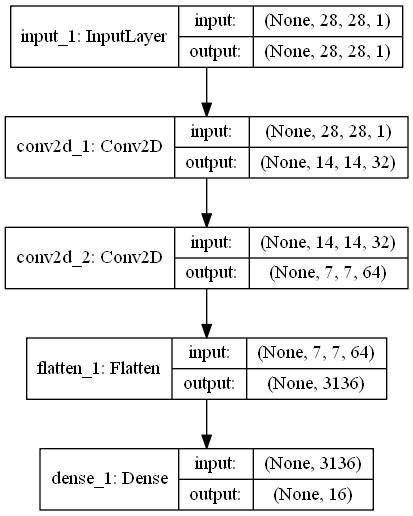

In [4]:
inputs = Input(shape=(28,28,1))
x=Conv2D(32,3,activation='relu', strides=2, padding='same')(inputs)
x=Conv2D(64,3,activation='relu', strides=2, padding='same')(x)

shape = K.int_shape(x)
x = Flatten()(x)
latent_z = Dense(16)(x)

encoder = Model(inputs,latent_z)
encoder.summary()
plot_model(encoder,
           to_file='encoder.png',
           show_shapes=True)


Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3136)              53312     
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 108,993
Trainable params: 108,993
Non-trainable params: 0
_____________________________________________________

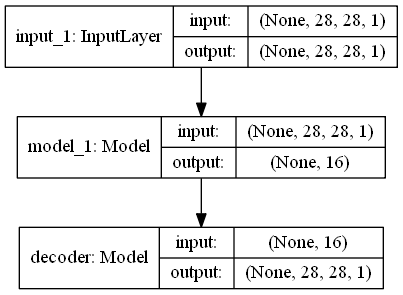

In [5]:
latent_inputs = Input(shape=(16,))
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
x = Conv2DTranspose(64,3,activation='relu',strides=2,padding='same')(x)
x = Conv2DTranspose(32,3,activation='relu',strides=2,padding='same')(x)
x_tilde= Conv2DTranspose(1,3,activation='sigmoid',padding='same')(x)

decoder = Model(latent_inputs, x_tilde, name='decoder')
decoder.summary()
plot_model(decoder, to_file='decoder.png', show_shapes=True)

autoencoder = Model(inputs,
                    decoder(encoder(inputs)))
autoencoder.summary()
plot_model(autoencoder,
           to_file='autoencoder.png',
           show_shapes=True)


In [6]:
autoencoder=Model(input,decoder(encoder(input)))
autoencoder.compile(loss='mse', optimizer='adam')
autoencoder.fit(x_train, x_train, validation_data=(x_test, x_test), epochs=10, batch_size=32)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 28s 468us/step - loss: 0.0218 - val_loss: 0.0103
Epoch 2/10
60000/60000 [==============================] - 28s 462us/step - loss: 0.0097 - val_loss: 0.0088
Epoch 3/10
60000/60000 [==============================] - 28s 461us/step - loss: 0.0087 - val_loss: 0.0083
Epoch 4/10
60000/60000 [==============================] - 28s 465us/step - loss: 0.0081 - val_loss: 0.0080
Epoch 5/10
60000/60000 [==============================] - 28s 465us/step - loss: 0.0078 - val_loss: 0.0077
Epoch 6/10
60000/60000 [==============================] - 28s 466us/step - loss: 0.0075 - val_loss: 0.0077
Epoch 7/10
60000/60000 [==============================] - 28s 468us/step - loss: 0.0073 - val_loss: 0.0073
Epoch 8/10
60000/60000 [==============================] - 28s 464us/step - loss: 0.0072 - val_loss: 0.0073
Epoch 9/10
60000/60000 [==============================] - 28s 465us/step - loss: 0.0070 - val_

In [7]:
x_decoded = autoencoder.predict(x_test)

imgs = np.concatenate([x_test[:8], x_decoded[:8]])
imgs.shape

(16, 28, 28, 1)

In [8]:
imgs = imgs.reshape((4, 4, image_size, image_size))
imgs.shape

(4, 4, 28, 28)

In [9]:
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs.shape

(112, 112)

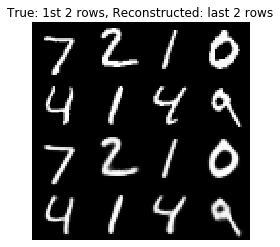

In [11]:
plt.figure()
plt.axis('off')
plt.title('True: 1st 2 rows, Reconstructed: last 2 rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.show()
